In [990]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 9, 5

# Реалізація МНКО

In [991]:
def LSMB(X, y, s=None, sigma_estimation=None, verbose=False,
         deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = LSMB(X[:,:-1], y, s, sigma_estimation,
                                     verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = LSMB(X[:,:-1], y, s, sigma_estimation,
                                 verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS 
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            if sigma_estimation is None:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE', 'theta'])
            else:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp_simple',
                                           'Cp', 'FPE', 'theta'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        Cp_simple = RSS_next + 2 * m
        if sigma_estimation is None:
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp': Cp_simple, 'FPE': FPE,
                            'theta': w[:, 0]},
                           ignore_index=True)
        else:
            Cp = RSS_next + 2 * sigma_estimation * m
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp_simple': Cp_simple,
                            'Cp': Cp, 'FPE': FPE,
                            'theta': w[:, 0]},
                           ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

In [992]:
w, H_next_inv, RSS_next, df = LSMB(config1.X, config1.y, create_dataframe=True)
df

,s,RSS,Cp,FPE,theta
0,1,204.390043,206.390043,204.799233,[2.2759720466391262]
1,2,118.526083,122.526083,119.001138,"[3.458044474699305, -1.568401469252666]"
2,3,88.528097,94.528097,89.060863,"[3.0518107290932113, -2.0496826386906752, 1.02..."
3,4,88.527881,96.527881,89.238948,"[3.052611522958968, -2.04883122028422, 1.02647..."
4,5,88.483885,98.483885,89.373171,"[3.061673978119901, -2.0389513760358287, 1.037..."


# Пошук моделі оптимальної складності

Метою роботи є пошук моделі оптимальної складності, причому наперед не відомо, яку саме підмножину всіх регресорів/аргументів містить така модель. Тому необхідно сконструювати і перевірити алгоритми для її пошуку.

In [1015]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.3
    s0 = 3
    s = m
    
    def __init__(self, m=None, s0=None, theta=None, a=None, b=None,
                 X=None, y=None):
        if m:
            self.m = m
            self.s = m
        if s0:
            self.s0 = s0
        if theta:
            if isinstance(theta, dict) and theta['random']:
                self.theta = np.zeros(self.m)
                self.theta[:self.s0] = np.random.uniform(*theta['random'],
                                                         size=self.s0)
            elif theta == 'unknown':
                assert X is not None, 'Please provide data (X)'
                assert y is not None, 'Please provide target values as well (y)'
                self.theta = theta
            else:
                self.theta = theta
        if a:
            self.a = a
        if b:
            self.b = b
        if X is not None:
            assert y is not None, 'Please provide target values as well (y)'
            self.X = np.array(X)
            self.y = np.array(y)
            (self.n, self.m) = X.shape
            self.s = self.m
        else:
            self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self, n=None, sigma=None):
        if n:
            self.n = n
        if sigma:
            self.sigma = sigma
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def show(self, n_limit=10):
        print('Regressors: m = {}'.format(self.m))
        print('True parameters: θ = {}'.format(self.theta))
        if not isinstance(self.theta, str):
            equation_str = ''
            for i, theta_i in enumerate(self.theta):
                equation_str += ' + ({}) * x{}'.format(theta_i, i+1)
            equation_str = 'y0 = '+ equation_str[3:]
            print(equation_str)
            print('Noise generation: σ = {}'.format(self.sigma))
        print('Sample length: n = {}'.format(self.n))
        print('X[:10]:\n{}'.format(self.X[:n_limit]))
        print('y[:10]:\n{}'.format(self.y[:n_limit]))
        
    def show_estimations(self):
        print('RSS(m) = {:5.5}'.format(self.RSS))
        print('σ* = {:5.5}'.format(self.sigma_hat ** .2))
    
    def estimate_sigma(self):
        _, _, self.RSS = RMNK(self.X, self.y, s=self.s,
                         verbose=False, create_dataframe=False)
        self.sigma_hat = self.RSS ** 2 / (self.X.shape[0] - self.X.shape[1])
        
    def run_grid_LSMB_model_selection(self):
        self.estimate_sigma()
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.compile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = LSMB(self.X, self.y, s=self.s,
                                            verbose=True, create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()
    
    def run_single_LSMB_model_selection(self, p=None, plot=False, 
                                        criteria=['Cp', 'FPE', 'RSS']):
        """Single LSMB
        
        p : list or str
            if list: permutation indices
            if str: one of 'direct', 'reverse', 'correlation'
                    defines how to create permutation
        """
        if p == 'reverse':
            print('=============\nREVERSE\n=============')
            p = np.flip(np.arange(self.m), axis=0)
        elif p == 'correlation':
            print('=====================\nCORRELATION INCLUDING\n=====================')
            correlations = np.abs(np.cov(self.X.T, self.y.T)[-1,:-1])
            p = np.argsort(-correlations)
        elif isinstance(p, list):
            print('=============\nCUSTOM\n=============')
        else:
            print('=============\nDIRECT\n=============')
            p = np.arange(self.m)
        print('Regressors order: {}'.format(p+1))
        theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=self.s,
                                    verbose=False, create_dataframe=True)
            
        df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
        for criterion in criteria:
            df[criterion] = np.round(df[criterion], 6)
        if plot:
            for criterion in criteria:
                plt.plot(df['s'], df[criterion], label=criterion)
                plt.legend()
                plt.show()
        df = df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors', 'theta'] + criteria]
        self.s_opt, self.regressors_opt, \
        self.theta_opt = df.loc[0, ['s', 'regressors', 'theta']]
        self.theta_opt = np.hstack((self.theta_opt,
                         np.zeros(self.m - len(self.theta_opt))))[np.argsort(p)]
        print('Optimal:')
        print('\ts* = {}'.format(self.s_opt))
        print('\tregressors = {}'.format(self.regressors_opt))
        print('\ttheta* = {}'.format(self.theta_opt))
        return df
    
    def run_single_full_LSMB_model_selection(self,
                                             criteria=['Cp', 'FPE', 'RSS']):
        print('=============\nBRUT FORCE\n=============')
        total_df = pd.DataFrame()
        for p in permutations(range(self.m)):
            p = np.array(p)
            theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df = df.drop(columns=['theta'])
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            total_df = pd.concat([total_df, df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        return total_df
    
    def run_single_random_LSMB_model_selection(self, K=20,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nRANDOM INCLUDING WITH K = {}\n================================'.format(K))
        permutations = [np.random.permutation(self.m) for k in range(K)]
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        for p in permutations:
            p = np.array(p)
            theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df = df.drop(columns=['theta'])
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            df = df.sort_values(by=criteria).reset_index()
            main_criterion_value = df.loc[0, main_criterion]
            if main_criterion_value < self.main_criterion_value:
                self.main_criterion_value = main_criterion_value
                self.theta_pred = theta_pred
                self.s_opt, self.regressors_opt = df.loc[0,
                                                         ['s', 'regressors']]
            total_df = pd.concat([total_df, df], axis=0)
            best_df = pd.concat([best_df, df.loc[0:0]], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print()
        print(best_df[:5])
        print('...')
        print(best_df[-5:])
        print()
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return total_df, best_df
    
    def run_single_picking_LSMB_model_selection(self,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nPICKING INCLUDING\n================================'.format(K))
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        remained_indices = list(range(self.m))
        regressors_indices = []
        while len(remained_indices) > 0:
            local_main_criterion_value = np.Inf
            for i in remained_indices:
                p = np.array(regressors_indices + [i])
                theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=len(p),
                                            verbose=False, create_dataframe=True)
                df = df.drop(columns=['theta'])
                df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
                df = df.sort_values(by=criteria).reset_index()
                main_criterion_value = df.loc[0, main_criterion]
                if main_criterion_value < local_main_criterion_value:
                    local_main_criterion_value = main_criterion_value
                    local_df = df[:1]
                    local_i = i
                if main_criterion_value < self.main_criterion_value:
                    self.main_criterion_value = main_criterion_value
                    self.theta_pred = theta_pred
                    self.s_opt, self.regressors_opt = df.loc[0, ['s', 'regressors']]
                total_df = pd.concat([total_df, df], axis=0)
            regressors_indices += [local_i]
            remained_indices.remove(local_i)
            best_df = pd.concat([best_df, local_df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates().reset_index()\
                   [['s', 'regressors'] + criteria]
#         total_df = total_df.sort_values(by=criteria).reset_index()\
#                    [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return total_df, best_df

## Задання конфігурацій. Створення вибірок

### Тест 1 (вибірка аналогічна вибірці з лабораторної роботи №2)

In [1016]:
config1 = ModelConfig(a=0, b=0.5)
config1.compile(n=1000)
config1.generate_noise_and_output()
config1.show()

Regressors: m = 5
True parameters: θ = [ 3 -2  1  0  0]
y0 = (3) * x1 + (-2) * x2 + (1) * x3 + (0) * x4 + (0) * x5
Noise generation: σ = 0.3
Sample length: n = 1000
X[:10]:
[[0.1530566  0.33318927 0.07441928 0.03217597 0.03730496]
 [0.01346067 0.30408284 0.24820128 0.01038765 0.49714093]
 [0.17959298 0.16279053 0.0964559  0.07469348 0.12877866]
 [0.17593867 0.34424211 0.04637942 0.3620204  0.2724424 ]
 [0.22354325 0.4644061  0.35433074 0.02787516 0.46990695]
 [0.23787455 0.0473001  0.16768244 0.36464685 0.19158682]
 [0.32489723 0.34214751 0.46482567 0.22501538 0.3450607 ]
 [0.41070179 0.09238383 0.25989456 0.24216799 0.37525752]
 [0.23985005 0.21443401 0.07228718 0.06448158 0.05824862]
 [0.25952813 0.42468432 0.49542437 0.18054462 0.42135419]]
y[:10]:
[ 0.08399392  0.09826914  0.24644461 -0.29720696  0.19843789  0.62261973
  1.10186896  1.3842933   0.1833675   0.39241744]


### Тест 2 (велика вибірка з великою кількістю регресорів)

In [1017]:
config2 = ModelConfig(m=15, s0=10, a=0, b=0.5, theta={'random': [1, 10]})
config2.compile(n=1000)
config2.generate_noise_and_output()
config2.show(5)

Regressors: m = 15
True parameters: θ = [5.6484407  2.85142117 5.42252073 1.4676631  8.48797504 1.97147992
 9.45018939 9.77608797 7.40937077 1.39397065 0.         0.
 0.         0.         0.        ]
y0 = (5.6484407009889885) * x1 + (2.8514211720383713) * x2 + (5.422520734238472) * x3 + (1.4676631013069994) * x4 + (8.487975044289264) * x5 + (1.9714799200432274) * x6 + (9.450189386819977) * x7 + (9.776087971119223) * x8 + (7.409370765058644) * x9 + (1.3939706501777567) * x10 + (0.0) * x11 + (0.0) * x12 + (0.0) * x13 + (0.0) * x14 + (0.0) * x15
Noise generation: σ = 0.3
Sample length: n = 1000
X[:10]:
[[0.40782554 0.40621718 0.42888195 0.18554478 0.1500313  0.00712395
  0.33421592 0.26304649 0.18108903 0.12002662 0.32963574 0.01752117
  0.00418598 0.47813364 0.17585088]
 [0.2247526  0.3006764  0.41761236 0.04710972 0.05369591 0.06971451
  0.19314543 0.28459513 0.28292296 0.14591944 0.27648981 0.10010028
  0.34658125 0.04927873 0.3917804 ]
 [0.3208896  0.29459365 0.37742984 0.36922192 0.

### Тест 3 (власні задачі)

#### Октан

При дослідженні виробничого процесу нафтопереробному заводі вимірюється вміст октану в нафті залежно від кількості 3-х сировинних матеріалів та змінної, що характеризує умови виробництва. Вхідні змінні (5):

- кількість матеріалу 1
- кількість матеріалу 2
- кількість матеріалу 3
- кількісний показник умов виробництва
- одиниця, відповідає вільному члену

Вихідна змінна:
- вміст октану

In [1036]:
dataframe_path = 'data/octane-rating.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'One':'Condition'],
                      y=df['Octane number'])
config3.show()

Regressors: m = 5
True parameters: θ = unknown
Sample length: n = 82
X[:10]:
[[ 1.      55.33     1.72    54.       1.66219]
 [ 1.      59.13     1.2     53.       1.58399]
 [ 1.      57.39     1.42    55.       1.61731]
 [ 1.      56.43     1.78    55.       1.66228]
 [ 1.      55.98     1.58    54.       1.63195]
 [ 1.      56.16     2.12    56.       1.68034]
 [ 1.      54.85     1.17    54.       1.58206]
 [ 1.      52.83     1.5     58.       1.54998]
 [ 1.      54.52     0.87    57.       1.5623 ]
 [ 1.      54.12     0.88    57.       1.57818]]
y[:10]:
[92.19 92.74 91.88 92.8  92.56 92.61 92.33 92.22 91.56 92.17]


#### Ціни на нерухомість


Вхідні змінні:
- The building class
- Linear feet of street connected to property
- Lot size in square feet
- Overall material and finish quality
- Overall condition rating
- Original construction date
- Remodel date
- Masonry veneer area in square feet
- Type 1 finished square feet
- Type 2 finished square feet
- Unfinished square feet of basement area
- Total square feet of basement area
- First Floor square feet
- Second floor square feet
- Low quality finished square feet (all floors)
- Above grade (ground) living area square feet
- Basement full bathrooms
- Basement half bathrooms
- Full bathrooms above grade
- Half baths above grade
- Number of bedrooms above basement level
- Number of kitchens
- Total rooms above grade (does not include bathrooms)
- Number of fireplaces
- Year garage was built
- Size of garage in car capacity
- Size of garage in square feet
- Wood deck area in square feet
- Open porch area in square feet
- Enclosed porch area in square feet
- Three season porch area in square feet
- Screen porch area in square feet
- Pool area in square feet
- Value of miscellaneous feature
- Month Sold
- Year Sold

Вихідна змінна:
- the property's sale price in dollars. This is the target variable that you're trying to predict.

In [1040]:
dataframe_path = 'data/house-prices-cleaned.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'MSSubClass':'YrSold'],
                      y=df['SalePrice'])
config3.show(1)

Regressors: m = 36
True parameters: θ = unknown
Sample length: n = 1460
X[:10]:
[[4.11087386e+00 4.18965474e+00 9.04204006e+00 7.00000000e+00
  5.00000000e+00 2.00300000e+03 2.00300000e+03 5.28320373e+00
  6.56103067e+00 0.00000000e+00 5.01727984e+00 6.75343792e+00
  6.75343792e+00 6.75110147e+00 0.00000000e+00 7.44483327e+00
  1.00000000e+00 0.00000000e+00 2.00000000e+00 1.00000000e+00
  3.00000000e+00 6.93147181e-01 8.00000000e+00 0.00000000e+00
  2.00300000e+03 2.00000000e+00 5.48000000e+02 0.00000000e+00
  4.12713439e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.00000000e+00 2.00800000e+03]]
y[:10]:
[12.24769912]


## Пошук моделі. Послідовне включення (метод з лабораторної роботи №2)

### Тест 1

DIRECT
Regressors order: [1 2 3 4 5]


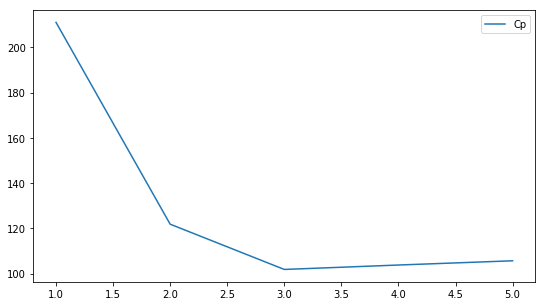

Optimal:
	s* = 3
	regressors = [1, 2, 3]
	theta* = [ 2.99081965 -1.93913701  0.87762842  0.          0.        ]

REVERSE
Regressors order: [5 4 3 2 1]


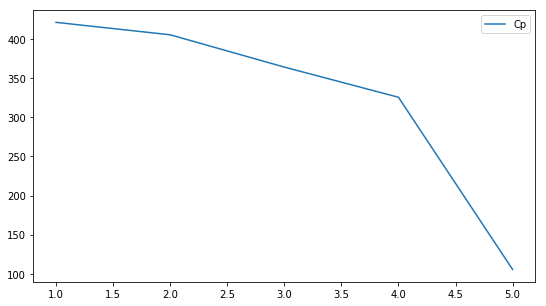

Optimal:
	s* = 5
	regressors = [1, 2, 3, 4, 5]
	theta* = [ 2.98709562 -1.94182866  0.87150877 -0.05824579  0.07321733]


In [997]:
df1 = config1.run_single_LSMB_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config1.run_single_LSMB_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 2

DIRECT
Regressors order: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


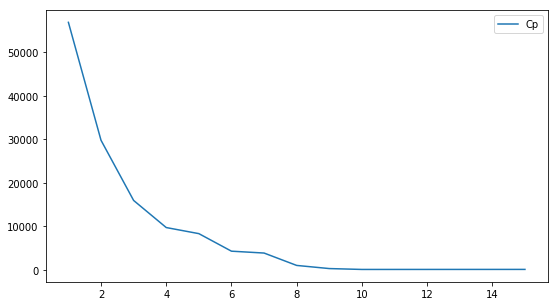

Optimal:
	s* = 10
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
	theta* = [4.91481988 4.75799549 9.95522095 8.54195863 1.73401532 9.72887578
 1.53192298 9.9273172  5.16610821 3.02866276 0.         0.
 0.         0.         0.        ]

REVERSE
Regressors order: [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1]


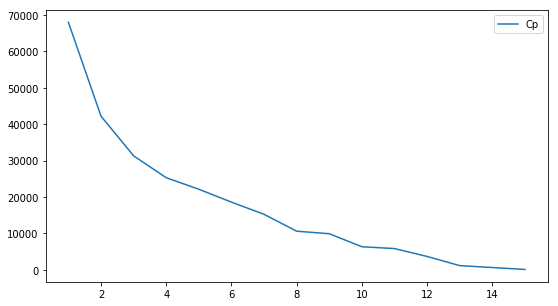

Optimal:
	s* = 15
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
	theta* = [ 4.90999168  4.75284829  9.95175882  8.54096413  1.73413002  9.71559185
  1.52884543  9.91128194  5.17148831  3.02673378 -0.01810493  0.09404331
  0.06450636 -0.07083847 -0.02641662]


In [998]:
df1 = config2.run_single_LSMB_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config2.run_single_LSMB_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 3

DIRECT
Regressors order: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


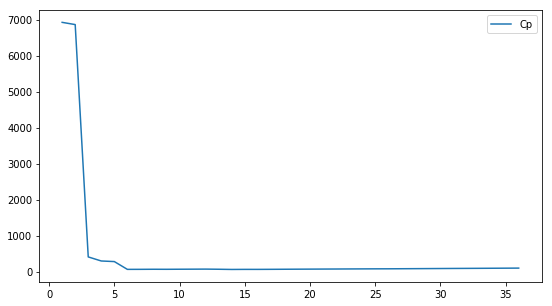

Optimal:
	s* = 14
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
	theta* = [-1.28216774e-02  1.35851253e-05  1.01151515e-01  1.25308956e-01
  4.12106912e-02  3.12536597e-03  3.92878641e-04 -4.94563646e-06
  1.29231643e-02 -2.45073557e-03 -3.51982790e-03  1.69078658e-02
  4.24867318e-01  3.14435770e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

REVERSE
Regressors order: [36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13
 12 11 10  9  8  7  6  5  4  3  2  1]


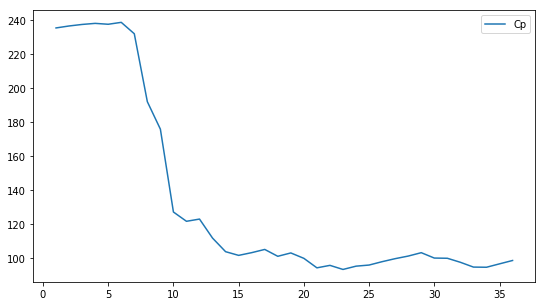

Optimal:
	s* = 23
	regressors = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
	theta* = [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.61098624e-02 -2.95063243e-02  6.48993848e-01
  9.19192746e-02  6.26520804e-02  1.20066421e-01  6.97063260e-02
 -4.17975867e-02 -7.73319356e-01  1.55498563e-02  3.57490733e-02
 -5.79498605e-07  9.78581656e-02  9.61967395e-05  9.14427971e-03
  1.01267236e-02 -8.23456848e-03  7.53719402e-03  7.69962764e-03
 -1.80806774e-02 -4.87035069e-03  1.07276179e-03  3.69006575e-03]


In [1039]:
df1 = config3.run_single_LSMB_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config3.run_single_LSMB_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

## Пошук моделі. Метод кореляційного включення

### Тест 1

True parameters: [ 3 -2  1  0  0]
CORRELATION INCLUDING
Regressors order: [1 2 3 4 5]


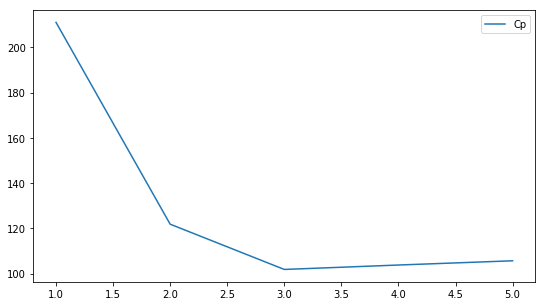

Optimal:
	s* = 3
	regressors = [1, 2, 3]
	theta* = [ 2.99081965 -1.93913701  0.87762842  0.          0.        ]


In [1000]:
print('True parameters: {}'.format(config1.theta))
df1 = config1.run_single_LSMB_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 2

True parameters: [4.96664479 4.7649021  9.99047967 8.43234216 1.84433743 9.63130901
 1.56560961 9.95328146 5.15487987 2.98337506 0.         0.
 0.         0.         0.        ]
CORRELATION INCLUDING
Regressors order: [ 6  3  8  4  1  9  2 10  5 13 15  7 11 14 12]


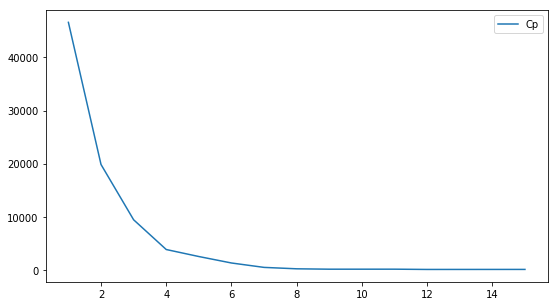

Optimal:
	s* = 12
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15]
	theta* = [ 4.9130709   4.75597687  9.94916244  8.53917578  1.73402114  9.72060934
  1.52757603  9.92184447  5.16388873  3.02373494  0.          0.
  0.06342858  0.         -0.02503112]


In [1001]:
print('True parameters: {}'.format(config2.theta))
df1 = config2.run_single_LSMB_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 3

True parameters: unknown
CORRELATION INCLUDING
Regressors order: [2 4 3 5 1]


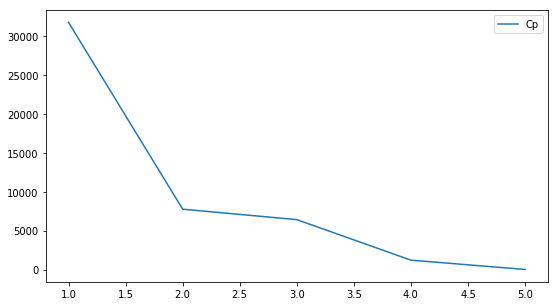

Optimal:
	s* = 5
	regressors = [1, 2, 3, 4, 5]
	theta* = [ 9.58531502e+01 -9.28205703e-02 -1.26798353e-01 -2.53806824e-02
  1.96760297e+00]


In [1028]:
print('True parameters: {}'.format(config3.theta))
df1 = config3.run_single_LSMB_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

## Пошук моделі. Метод випадкового включення

### Тест 1

In [1003]:
Ks = [10, 20, 50]
for K in Ks:
    config1.run_single_random_LSMB_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

  s*      regressors*          Cp
0  5  [1, 2, 3, 4, 5]  105.661296
1  5  [1, 2, 3, 4, 5]  105.661296
2  5  [1, 2, 3, 4, 5]  105.661296
3  5  [1, 2, 3, 4, 5]  105.661296
4  5  [1, 2, 3, 4, 5]  105.661296
...
  s*      regressors*          Cp
5  4     [1, 2, 3, 5]  103.749412
6  3        [1, 2, 3]  101.837846
7  5  [1, 2, 3, 4, 5]  105.661296
8  5  [1, 2, 3, 4, 5]  105.661296
9  4     [1, 2, 3, 5]  103.749412

Optimal:
	s* = 3
	regressors = [1, 2, 3]
RANDOM INCLUDING WITH K = 20

  s*      regressors*          Cp
0  5  [1, 2, 3, 4, 5]  105.661296
1  5  [1, 2, 3, 4, 5]  105.661296
2  4     [1, 2, 3, 5]  103.749412
3  3        [1, 2, 3]  101.837846
4  3        [1, 2, 3]  101.837846
...
   s*      regressors*          Cp
15  5  [1, 2, 3, 4, 5]  105.661296
16  5  [1, 2, 3, 4, 5]  105.661296
17  4     [1, 2, 3, 5]  103.749412
18  4     [1, 2, 3, 5]  103.749412
19  5  [1, 2, 3, 4, 5]  105.661296

Optimal:
	s* = 3
	regressors = [1, 2, 3]
RANDOM INCLUDING WITH K = 

### Тест 2

In [1004]:
Ks = [10, 20, 50]
for K in Ks:
    config2.run_single_random_LSMB_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

   s*                                        regressors*          Cp
0  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620
1  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620
2  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620
3  14    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]  118.792097
4  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620
...
   s*                                        regressors*          Cp
5  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620
6  13        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]  116.708132
7  14    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]  118.792097
8  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620
9  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  120.684620

Optimal:
	s* = 13
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
RANDOM INCLUDING WITH K = 20

   s*                          

### Тест 3

In [1029]:
Ks = [10, 20, 50, 100]
for K in Ks:
    config3.run_single_random_LSMB_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

  s*      regressors*         Cp
0  4     [1, 2, 3, 5]  23.649432
1  5  [1, 2, 3, 4, 5]  25.006253
2  4     [1, 2, 3, 5]  23.649432
3  5  [1, 2, 3, 4, 5]  25.006253
4  5  [1, 2, 3, 4, 5]  25.006253
...
  s*      regressors*         Cp
5  5  [1, 2, 3, 4, 5]  25.006253
6  4     [1, 2, 3, 5]  23.649432
7  3        [1, 2, 5]  24.414852
8  5  [1, 2, 3, 4, 5]  25.006253
9  5  [1, 2, 3, 4, 5]  25.006253

Optimal:
	s* = 4
	regressors = [1, 2, 3, 5]
RANDOM INCLUDING WITH K = 20

  s*      regressors*         Cp
0  5  [1, 2, 3, 4, 5]  25.006253
1  5  [1, 2, 3, 4, 5]  25.006253
2  4     [1, 2, 3, 5]  23.649432
3  5  [1, 2, 3, 4, 5]  25.006253
4  5  [1, 2, 3, 4, 5]  25.006253
...
   s*      regressors*         Cp
15  5  [1, 2, 3, 4, 5]  25.006253
16  4     [1, 2, 3, 5]  23.649432
17  5  [1, 2, 3, 4, 5]  25.006253
18  5  [1, 2, 3, 4, 5]  25.006253
19  5  [1, 2, 3, 4, 5]  25.006253

Optimal:
	s* = 4
	regressors = [1, 2, 3, 5]
RANDOM INCLUDING WITH K = 50

  s*      regr

## Пошук моделі. Метод перебірного включення

### Тест 1

In [1030]:
total_df, best_df = config1.run_single_picking_LSMB_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 3
	regressors = [1, 2, 3]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається) 

In [1007]:
total_df

,s,regressors,Cp
0,1,[1],211.044825
1,1,[2],519.711938
2,1,[3],369.799111
3,1,[4],433.168931
4,1,[5],421.142572
5,2,"[1, 2]",121.839276
6,2,"[1, 3]",212.955477
7,2,"[1, 4]",203.716977
8,2,"[1, 5]",207.232143
9,3,"[1, 2, 3]",101.837846


### Тест 2

In [1008]:
total_df, best_df = config2.run_single_picking_LSMB_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 10
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається) 

In [1009]:
total_df

,s,regressors,Cp
0,1,[1],56931.980047
1,1,[2],54440.837999
2,1,[3],45777.961780
3,1,[4],49004.360519
4,1,[5],60515.429680
5,1,[6],46609.318946
6,1,[7],62436.684190
7,1,[8],46897.847412
8,1,[9],54614.649295
9,1,[10],55782.761682


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [1010]:
best_df

,s*,regressors*,Cp
0,1,[3],45777.961780
1,2,"[3, 4]",19791.350035
2,3,"[3, 4, 6]",9404.902922
3,4,"[3, 4, 6, 8]",3863.925822
4,5,"[2, 3, 4, 6, 8]",2275.433046
5,6,"[2, 3, 4, 6, 8, 9]",1256.910202
6,7,"[1, 2, 3, 4, 6, 8, 9]",500.863275
7,8,"[1, 2, 3, 4, 6, 8, 9, 10]",235.909394
8,9,"[1, 2, 3, 4, 5, 6, 8, 9, 10]",162.079636
9,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",111.086756


### Тест 3

In [1031]:
total_df, best_df = config3.run_single_picking_LSMB_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 4
	regressors = [1, 2, 3, 5]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається) 

In [1032]:
total_df

,s,regressors,Cp
0,1,[1],161.015099
1,1,[2],31768.421319
2,1,[3],385898.725361
3,1,[4],7804.044474
4,1,[5],10669.941326
5,2,"[1, 2]",42.612528
6,2,"[1, 3]",138.535392
7,2,"[1, 4]",98.189483
8,2,"[1, 5]",100.156272
9,3,"[1, 2, 3]",41.070824


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [1033]:
best_df

,s*,regressors*,Cp
0,1,[1],161.015099
1,2,"[1, 2]",42.612528
2,3,"[1, 2, 5]",24.414852
3,4,"[1, 2, 3, 5]",23.649432
4,4,"[1, 2, 3, 5]",23.649432
